Found 200 matching SAR-EO pairs out of 200 SAR files and 200 EO files
First few matching pairs:
  SAR: ROIs2017_winter_s1_102_p339.tif <-> EO: ROIs2017_winter_s2_102_p339.tif
  SAR: ROIs2017_winter_s1_102_p491.tif <-> EO: ROIs2017_winter_s2_102_p491.tif
  SAR: ROIs2017_winter_s1_102_p685.tif <-> EO: ROIs2017_winter_s2_102_p685.tif
  SAR: ROIs2017_winter_s1_102_p77.tif <-> EO: ROIs2017_winter_s2_102_p77.tif
  SAR: ROIs2017_winter_s1_102_p888.tif <-> EO: ROIs2017_winter_s2_102_p888.tif

Visualizing augmentations for: SAR=ROIs2017_winter_s1_102_p339.tif, EO=ROIs2017_winter_s2_102_p339.tif


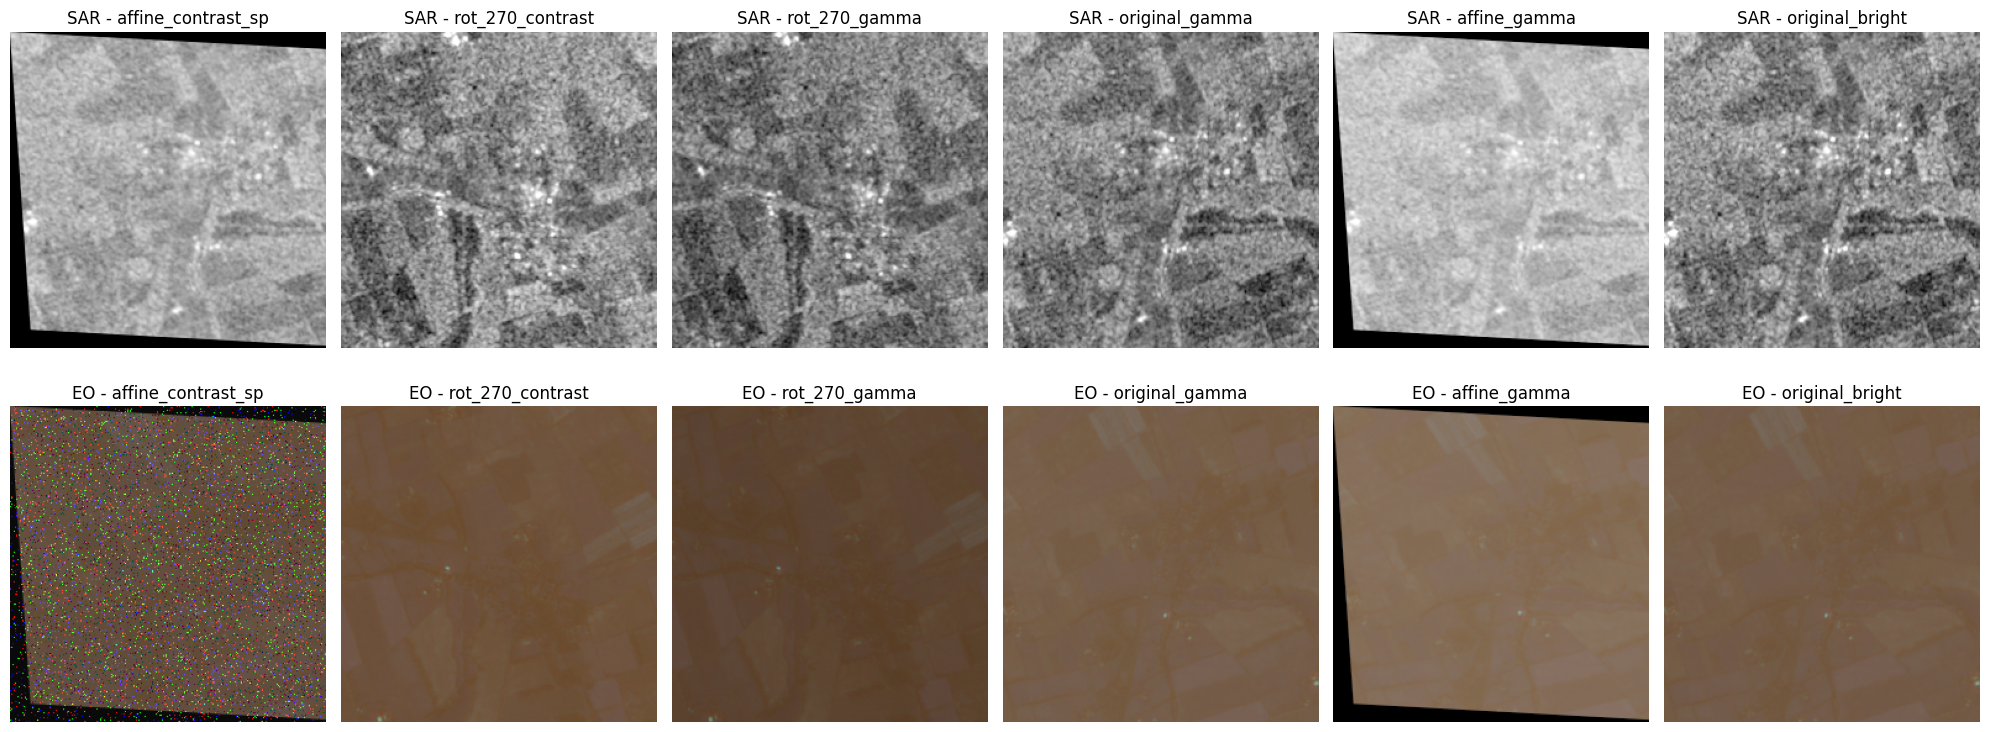


Processing entire dataset...
Found 200 matching SAR-EO pairs out of 200 SAR files and 200 EO files
Processing 200 matching image pairs...


Augmenting dataset: 100%|████████████████████████████████████████████████████████████| 200/200 [00:51<00:00,  3.88it/s]


Augmentation complete!
Original pairs: 200
Augmented files created: 989
Failed pairs: 0
Augmentation techniques used: 217

Validating augmented samples...
Validating ROIs2017_winter_s1_117_p343_flip_horizontal.tif...
Error validating ROIs2017_winter_s1_117_p343_flip_horizontal.tif: C:\Users\adars\Downloads\SAR-to-EO\augmented_dataset\EO\ROIs2017_winter_s1_117_p343_flip_horizontal.tif: No such file or directory
Validating ROIs2017_winter_s1_138_p308_original.tif...
Error validating ROIs2017_winter_s1_138_p308_original.tif: C:\Users\adars\Downloads\SAR-to-EO\augmented_dataset\EO\ROIs2017_winter_s1_138_p308_original.tif: No such file or directory
Validating ROIs2017_winter_s1_64_p513_affine.tif...
Error validating ROIs2017_winter_s1_64_p513_affine.tif: C:\Users\adars\Downloads\SAR-to-EO\augmented_dataset\EO\ROIs2017_winter_s1_64_p513_affine.tif: No such file or directory


In [1]:
import os
import numpy as np
import cv2
import random
from pathlib import Path
import matplotlib.pyplot as plt
from skimage import exposure, transform, util
from skimage.filters import gaussian
import rasterio
from rasterio.enums import Resampling
import albumentations as A
from typing import Tuple, List, Dict, Optional
import json
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

class SARGeoAugmentationPipeline:
    """
    Comprehensive augmentation pipeline for SAR-to-EO dataset pairs
    """
    
    def __init__(self, sar_folder: str, eo_folder: str, output_folder: str = None):
        self.sar_folder = Path(sar_folder)
        self.eo_folder = Path(eo_folder)
        self.output_folder = Path(output_folder) if output_folder else Path("augmented_data")
        
        # Create output directories
        self.output_sar = self.output_folder / "SAR"
        self.output_eo = self.output_folder / "EO"
        self.output_sar.mkdir(parents=True, exist_ok=True)
        self.output_eo.mkdir(parents=True, exist_ok=True)
        
        # Augmentation configuration
        self.augmentation_config = {
            'geometric': {
                'rotation_probability': 0.7,
                'flip_probability': 0.5,
                'crop_probability': 0.6,
                'affine_probability': 0.4,
                'rotation_angles': [90, 180, 270],
                'crop_size_range': (0.7, 0.9)
            },
            'intensity': {
                'brightness_probability': 0.5,
                'contrast_probability': 0.5,
                'gamma_probability': 0.4,
                'histogram_eq_probability': 0.3,
                'brightness_range': (-0.2, 0.2),
                'contrast_range': (0.8, 1.2),
                'gamma_range': (0.7, 1.3)
            },
            'noise': {
                'gaussian_probability': 0.4,
                'salt_pepper_probability': 0.3,
                'multiplicative_probability': 0.3,
                'gaussian_var_range': (0.001, 0.01),
                'salt_pepper_amount': 0.05,
                'multiplicative_range': (0.9, 1.1)
            }
        }
    
    def find_matching_files(self) -> List[Tuple[str, str]]:
        """Find matching SAR and EO file pairs"""
        sar_files = list(self.sar_folder.glob("*.tif"))
        eo_files = list(self.eo_folder.glob("*.tif"))
        
        # Create dictionaries for easier matching
        sar_dict = {}
        eo_dict = {}
        
        # Extract base patterns from filenames
        for sar_file in sar_files:
            # Extract pattern like "ROIs2017_winter_s1_94_p83" -> "ROIs2017_winter_94_p83"
            name = sar_file.stem
            # Remove sensor identifier (s1, s2, etc.)
            parts = name.split('_')
            if len(parts) >= 4:
                base_pattern = f"{parts[0]}_{parts[1]}_{parts[3]}_{parts[4]}"
                sar_dict[base_pattern] = sar_file.name
        
        for eo_file in eo_files:
            name = eo_file.stem
            parts = name.split('_')
            if len(parts) >= 4:
                base_pattern = f"{parts[0]}_{parts[1]}_{parts[3]}_{parts[4]}"
                eo_dict[base_pattern] = eo_file.name
        
        # Find matching pairs
        matching_pairs = []
        for pattern in sar_dict:
            if pattern in eo_dict:
                matching_pairs.append((sar_dict[pattern], eo_dict[pattern]))
        
        print(f"Found {len(matching_pairs)} matching SAR-EO pairs out of {len(sar_files)} SAR files and {len(eo_files)} EO files")
        return matching_pairs
    
    def load_image_pair(self, sar_filename: str, eo_filename: str) -> Tuple[np.ndarray, np.ndarray]:
        """Load corresponding SAR and EO images"""
        sar_path = self.sar_folder / sar_filename
        eo_path = self.eo_folder / eo_filename
        
        try:
            # Load SAR image
            with rasterio.open(sar_path) as src:
                sar_img = src.read().transpose(1, 2, 0)
                if sar_img.shape[2] == 1:
                    sar_img = sar_img.squeeze()
            
            # Load EO image
            with rasterio.open(eo_path) as src:
                eo_img = src.read().transpose(1, 2, 0)
            
            return sar_img, eo_img
            
        except Exception as e:
            print(f"Error loading SAR: {sar_filename}, EO: {eo_filename}: {e}")
            return None, None
    
    def save_image_pair(self, sar_img: np.ndarray, eo_img: np.ndarray, 
                       sar_filename: str, eo_filename: str, suffix: str = ""):
        """Save augmented SAR and EO image pair"""
        sar_base_name = Path(sar_filename).stem
        eo_base_name = Path(eo_filename).stem
        ext = Path(sar_filename).suffix
        
        if suffix:
            new_sar_filename = f"{sar_base_name}_{suffix}{ext}"
            new_eo_filename = f"{eo_base_name}_{suffix}{ext}"
        else:
            new_sar_filename = sar_filename
            new_eo_filename = eo_filename
        
        sar_output = self.output_sar / new_sar_filename
        eo_output = self.output_eo / new_eo_filename
        
        # Save SAR image
        if len(sar_img.shape) == 2:
            sar_img = sar_img[np.newaxis, :, :]
        else:
            sar_img = sar_img.transpose(2, 0, 1)
        
        with rasterio.open(
            sar_output, 'w',
            driver='GTiff',
            height=sar_img.shape[1],
            width=sar_img.shape[2],
            count=sar_img.shape[0],
            dtype=sar_img.dtype
        ) as dst:
            dst.write(sar_img)
        
        # Save EO image
        eo_img = eo_img.transpose(2, 0, 1)
        with rasterio.open(
            eo_output, 'w',
            driver='GTiff',
            height=eo_img.shape[1],
            width=eo_img.shape[2],
            count=eo_img.shape[0],
            dtype=eo_img.dtype
        ) as dst:
            dst.write(eo_img)
    
    # GEOMETRIC AUGMENTATIONS
    def apply_rotation(self, sar_img: np.ndarray, eo_img: np.ndarray, 
                      angle: int) -> Tuple[np.ndarray, np.ndarray]:
        """Apply synchronized rotation to both images"""
        k = angle // 90  # Number of 90-degree rotations
        sar_rotated = np.rot90(sar_img, k)
        eo_rotated = np.rot90(eo_img, k)
        return sar_rotated, eo_rotated
    
    def apply_flip(self, sar_img: np.ndarray, eo_img: np.ndarray, 
                   direction: str) -> Tuple[np.ndarray, np.ndarray]:
        """Apply synchronized flipping"""
        if direction == 'horizontal':
            sar_flipped = np.fliplr(sar_img)
            eo_flipped = np.fliplr(eo_img)
        elif direction == 'vertical':
            sar_flipped = np.flipud(sar_img)
            eo_flipped = np.flipud(eo_img)
        else:
            return sar_img, eo_img
        
        return sar_flipped, eo_flipped
    
    def apply_random_crop(self, sar_img: np.ndarray, eo_img: np.ndarray, 
                         crop_factor: float) -> Tuple[np.ndarray, np.ndarray]:
        """Apply synchronized random cropping"""
        h, w = sar_img.shape[:2]
        new_h, new_w = int(h * crop_factor), int(w * crop_factor)
        
        top = random.randint(0, h - new_h)
        left = random.randint(0, w - new_w)
        
        if len(sar_img.shape) == 2:
            sar_cropped = sar_img[top:top+new_h, left:left+new_w]
        else:
            sar_cropped = sar_img[top:top+new_h, left:left+new_w, :]
        
        eo_cropped = eo_img[top:top+new_h, left:left+new_w, :]
        
        # Resize back to original size
        sar_cropped = cv2.resize(sar_cropped, (w, h))
        eo_cropped = cv2.resize(eo_cropped, (w, h))
        
        return sar_cropped, eo_cropped
    
    def apply_affine_transform(self, sar_img: np.ndarray, eo_img: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Apply synchronized affine transformation"""
        h, w = sar_img.shape[:2]
        
        # Generate random affine parameters
        shear_x = random.uniform(-0.1, 0.1)
        shear_y = random.uniform(-0.1, 0.1)
        scale_x = random.uniform(0.9, 1.1)
        scale_y = random.uniform(0.9, 1.1)
        
        # Create affine transformation matrix
        transform_matrix = np.array([
            [scale_x, shear_x, 0],
            [shear_y, scale_y, 0],
            [0, 0, 1]
        ])
        
        # Apply transformation
        if len(sar_img.shape) == 2:
            sar_transformed = cv2.warpAffine(sar_img, transform_matrix[:2], (w, h))
        else:
            sar_transformed = cv2.warpAffine(sar_img, transform_matrix[:2], (w, h))
        
        eo_transformed = cv2.warpAffine(eo_img, transform_matrix[:2], (w, h))
        
        return sar_transformed, eo_transformed
    
    # INTENSITY AUGMENTATIONS
    def adjust_brightness(self, img: np.ndarray, factor: float) -> np.ndarray:
        """Adjust image brightness"""
        return np.clip(img + factor, 0, 1)
    
    def adjust_contrast(self, img: np.ndarray, factor: float) -> np.ndarray:
        """Adjust image contrast"""
        mean = np.mean(img)
        return np.clip((img - mean) * factor + mean, 0, 1)
    
    def apply_gamma_correction(self, img: np.ndarray, gamma: float) -> np.ndarray:
        """Apply gamma correction"""
        return np.power(img, gamma)
    
    def apply_histogram_equalization(self, img: np.ndarray) -> np.ndarray:
        """Apply histogram equalization"""
        if len(img.shape) == 2:
            return exposure.equalize_hist(img)
        else:
            # Apply to each channel separately
            result = np.zeros_like(img)
            for i in range(img.shape[2]):
                result[:, :, i] = exposure.equalize_hist(img[:, :, i])
            return result
    
    # NOISE AUGMENTATIONS
    def add_gaussian_noise(self, img: np.ndarray, var: float) -> np.ndarray:
        """Add Gaussian noise"""
        noise = np.random.normal(0, np.sqrt(var), img.shape)
        return np.clip(img + noise, 0, 1)
    
    def add_salt_pepper_noise(self, img: np.ndarray, amount: float) -> np.ndarray:
        """Add salt and pepper noise"""
        return util.random_noise(img, mode='s&p', amount=amount)
    
    def add_multiplicative_noise(self, img: np.ndarray, factor_range: Tuple[float, float]) -> np.ndarray:
        """Add multiplicative noise (useful for SAR)"""
        factor = random.uniform(*factor_range)
        noise = np.random.normal(1, 0.1, img.shape)
        return np.clip(img * noise * factor, 0, 1)
    
    def augment_image_pair(self, sar_img: np.ndarray, eo_img: np.ndarray) -> List[Tuple[np.ndarray, np.ndarray, str]]:
        """Apply augmentation pipeline to image pair"""
        augmented_pairs = []
        
        # Normalize images to [0, 1] range
        sar_norm = (sar_img - sar_img.min()) / (sar_img.max() - sar_img.min() + 1e-8)
        eo_norm = (eo_img - eo_img.min()) / (eo_img.max() - eo_img.min() + 1e-8)
        
        # Original pair
        augmented_pairs.append((sar_norm, eo_norm, "original"))
        
        # Geometric augmentations
        config = self.augmentation_config
        
        # Rotation
        if random.random() < config['geometric']['rotation_probability']:
            angle = random.choice(config['geometric']['rotation_angles'])
            sar_rot, eo_rot = self.apply_rotation(sar_norm, eo_norm, angle)
            augmented_pairs.append((sar_rot, eo_rot, f"rot_{angle}"))
        
        # Flipping
        if random.random() < config['geometric']['flip_probability']:
            direction = random.choice(['horizontal', 'vertical'])
            sar_flip, eo_flip = self.apply_flip(sar_norm, eo_norm, direction)
            augmented_pairs.append((sar_flip, eo_flip, f"flip_{direction}"))
        
        # Random cropping
        if random.random() < config['geometric']['crop_probability']:
            crop_factor = random.uniform(*config['geometric']['crop_size_range'])
            sar_crop, eo_crop = self.apply_random_crop(sar_norm, eo_norm, crop_factor)
            augmented_pairs.append((sar_crop, eo_crop, f"crop_{crop_factor:.2f}"))
        
        # Affine transformation
        if random.random() < config['geometric']['affine_probability']:
            sar_affine, eo_affine = self.apply_affine_transform(sar_norm, eo_norm)
            augmented_pairs.append((sar_affine, eo_affine, "affine"))
        
        # Intensity augmentations (applied independently)
        current_pairs = augmented_pairs.copy()
        
        for sar_aug, eo_aug, suffix in current_pairs:
            # Brightness adjustment
            if random.random() < config['intensity']['brightness_probability']:
                brightness_factor = random.uniform(*config['intensity']['brightness_range'])
                sar_bright = self.adjust_brightness(sar_aug, brightness_factor)
                eo_bright = self.adjust_brightness(eo_aug, brightness_factor)
                augmented_pairs.append((sar_bright, eo_bright, f"{suffix}_bright"))
            
            # Contrast adjustment
            if random.random() < config['intensity']['contrast_probability']:
                contrast_factor = random.uniform(*config['intensity']['contrast_range'])
                sar_contrast = self.adjust_contrast(sar_aug, contrast_factor)
                eo_contrast = self.adjust_contrast(eo_aug, contrast_factor)
                augmented_pairs.append((sar_contrast, eo_contrast, f"{suffix}_contrast"))
            
            # Gamma correction
            if random.random() < config['intensity']['gamma_probability']:
                gamma_factor = random.uniform(*config['intensity']['gamma_range'])
                sar_gamma = self.apply_gamma_correction(sar_aug, gamma_factor)
                eo_gamma = self.apply_gamma_correction(eo_aug, gamma_factor)
                augmented_pairs.append((sar_gamma, eo_gamma, f"{suffix}_gamma"))
        
        # Noise augmentations (applied to some pairs)
        noise_pairs = random.sample(augmented_pairs, min(3, len(augmented_pairs)))
        
        for sar_aug, eo_aug, suffix in noise_pairs:
            # Gaussian noise
            if random.random() < config['noise']['gaussian_probability']:
                noise_var = random.uniform(*config['noise']['gaussian_var_range'])
                sar_gauss = self.add_gaussian_noise(sar_aug, noise_var)
                eo_gauss = self.add_gaussian_noise(eo_aug, noise_var)
                augmented_pairs.append((sar_gauss, eo_gauss, f"{suffix}_gauss"))
            
            # Salt and pepper noise
            if random.random() < config['noise']['salt_pepper_probability']:
                eo_sp = self.add_salt_pepper_noise(eo_aug, config['noise']['salt_pepper_amount'])
                augmented_pairs.append((sar_aug, eo_sp, f"{suffix}_sp"))
            
            # Multiplicative noise for SAR
            if random.random() < config['noise']['multiplicative_probability']:
                sar_mult = self.add_multiplicative_noise(sar_aug, config['noise']['multiplicative_range'])
                augmented_pairs.append((sar_mult, eo_aug, f"{suffix}_mult"))
        
        return augmented_pairs
    
    def visualize_augmentations(self, sar_filename: str, eo_filename: str, max_samples: int = 6):
        """Visualize augmentation results"""
        sar_img, eo_img = self.load_image_pair(sar_filename, eo_filename)
        if sar_img is None or eo_img is None:
            return
        
        augmented_pairs = self.augment_image_pair(sar_img, eo_img)
        samples = random.sample(augmented_pairs, min(max_samples, len(augmented_pairs)))
        
        fig, axes = plt.subplots(2, len(samples), figsize=(20, 8))
        if len(samples) == 1:
            axes = axes.reshape(2, 1)
        
        for i, (sar_aug, eo_aug, suffix) in enumerate(samples):
            # Display SAR image
            if len(sar_aug.shape) == 2:
                axes[0, i].imshow(sar_aug, cmap='gray')
            else:
                axes[0, i].imshow(sar_aug[:, :, 0], cmap='gray')
            axes[0, i].set_title(f'SAR - {suffix}')
            axes[0, i].axis('off')
            
            # Display EO image
            if eo_aug.shape[2] >= 3:
                axes[1, i].imshow(eo_aug[:, :, :3])
            else:
                axes[1, i].imshow(eo_aug[:, :, 0], cmap='gray')
            axes[1, i].set_title(f'EO - {suffix}')
            axes[1, i].axis('off')
        
        plt.tight_layout()
        plt.savefig(self.output_folder / f'augmentation_preview_{Path(sar_filename).stem}.png', 
                   dpi=150, bbox_inches='tight')
        plt.show()
    
    def process_dataset(self, augmentation_factor: int = 5, validate_samples: bool = True):
        """Process entire dataset with augmentation"""
        # Get matching file pairs
        matching_pairs = self.find_matching_files()
        
        if not matching_pairs:
            print("No matching SAR-EO pairs found!")
            return
        
        stats = {
            'original_pairs': len(matching_pairs),
            'augmented_files': 0,
            'failed_pairs': 0,
            'augmentation_techniques': []
        }
        
        print(f"Processing {len(matching_pairs)} matching image pairs...")
        
        for sar_filename, eo_filename in tqdm(matching_pairs, desc="Augmenting dataset"):
            # Load image pair
            sar_img, eo_img = self.load_image_pair(sar_filename, eo_filename)
            if sar_img is None or eo_img is None:
                stats['failed_pairs'] += 1
                continue
            
            # Generate augmentations
            augmented_pairs = self.augment_image_pair(sar_img, eo_img)
            
            # Limit number of augmentations
            if len(augmented_pairs) > augmentation_factor:
                augmented_pairs = random.sample(augmented_pairs, augmentation_factor)
            
            # Save augmented pairs
            for sar_aug, eo_aug, suffix in augmented_pairs:
                try:
                    # Convert back to original data type and range
                    sar_final = (sar_aug * (sar_img.max() - sar_img.min()) + sar_img.min()).astype(sar_img.dtype)
                    eo_final = (eo_aug * (eo_img.max() - eo_img.min()) + eo_img.min()).astype(eo_img.dtype)
                    
                    self.save_image_pair(sar_final, eo_final, sar_filename, eo_filename, suffix)
                    stats['augmented_files'] += 1
                    
                    if suffix not in stats['augmentation_techniques']:
                        stats['augmentation_techniques'].append(suffix)
                        
                except Exception as e:
                    print(f"Error saving augmented pair {sar_filename}_{suffix}: {e}")
                    stats['failed_pairs'] += 1
        
        # Save statistics
        with open(self.output_folder / 'augmentation_stats.json', 'w') as f:
            json.dump(stats, f, indent=2)
        
        print(f"\nAugmentation complete!")
        print(f"Original pairs: {stats['original_pairs']}")
        print(f"Augmented files created: {stats['augmented_files']}")
        print(f"Failed pairs: {stats['failed_pairs']}")
        print(f"Augmentation techniques used: {len(stats['augmentation_techniques'])}")
        
        return stats
    
    def validate_augmented_samples(self, num_samples: int = 5):
        """Validate augmented samples by visualizing them"""
        augmented_files = list(self.output_sar.glob("*.tif"))
        if not augmented_files:
            print("No augmented files found!")
            return
        
        sample_files = random.sample(augmented_files, min(num_samples, len(augmented_files)))
        
        for file in sample_files:
            filename = file.name
            print(f"Validating {filename}...")
            
            # Load augmented pair
            try:
                with rasterio.open(self.output_sar / filename) as src:
                    sar_aug = src.read().transpose(1, 2, 0)
                    if sar_aug.shape[2] == 1:
                        sar_aug = sar_aug.squeeze()
                
                with rasterio.open(self.output_eo / filename) as src:
                    eo_aug = src.read().transpose(1, 2, 0)
                
                # Display
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
                
                if len(sar_aug.shape) == 2:
                    ax1.imshow(sar_aug, cmap='gray')
                else:
                    ax1.imshow(sar_aug[:, :, 0], cmap='gray')
                ax1.set_title(f'SAR - {filename}')
                ax1.axis('off')
                
                if eo_aug.shape[2] >= 3:
                    ax2.imshow(eo_aug[:, :, :3])
                else:
                    ax2.imshow(eo_aug[:, :, 0], cmap='gray')
                ax2.set_title(f'EO - {filename}')
                ax2.axis('off')
                
                plt.tight_layout()
                plt.show()
                
            except Exception as e:
                print(f"Error validating {filename}: {e}")


# Usage example
def main():
    # Define paths
    sar_folder = r"C:\Users\adars\Downloads\SAR-to-EO\subset\SAR"
    eo_folder = r"C:\Users\adars\Downloads\SAR-to-EO\subset\EO"
    output_folder = r"C:\Users\adars\Downloads\SAR-to-EO\augmented_dataset"
    
    # Initialize augmentation pipeline
    augmentor = SARGeoAugmentationPipeline(sar_folder, eo_folder, output_folder)
    
    # Find and display matching pairs
    matching_pairs = augmentor.find_matching_files()
    if matching_pairs:
        print(f"First few matching pairs:")
        for i, (sar_file, eo_file) in enumerate(matching_pairs[:5]):
            print(f"  SAR: {sar_file} <-> EO: {eo_file}")
        
        # Test with first matching pair
        test_sar, test_eo = matching_pairs[0]
        print(f"\nVisualizing augmentations for: SAR={test_sar}, EO={test_eo}")
        augmentor.visualize_augmentations(test_sar, test_eo, max_samples=6)
        
        # Process entire dataset
        print("\nProcessing entire dataset...")
        stats = augmentor.process_dataset(augmentation_factor=5, validate_samples=True)
        
        # Validate some augmented samples
        print("\nValidating augmented samples...")
        augmentor.validate_augmented_samples(num_samples=3)
        
        return augmentor, stats
    else:
        print("No matching pairs found. Please check your file naming convention.")
        return None, None

if __name__ == "__main__":
    augmentor, stats = main()

Starting validation of augmented SAR-EO dataset...
Found 5409 augmented SAR files

--- Validating Pair 1 ---
SAR: ROIs2017_winter_s1_108_p280_flip_horizontal.tif
EO:  ROIs2017_winter_s2_108_p280_flip_horizontal.tif


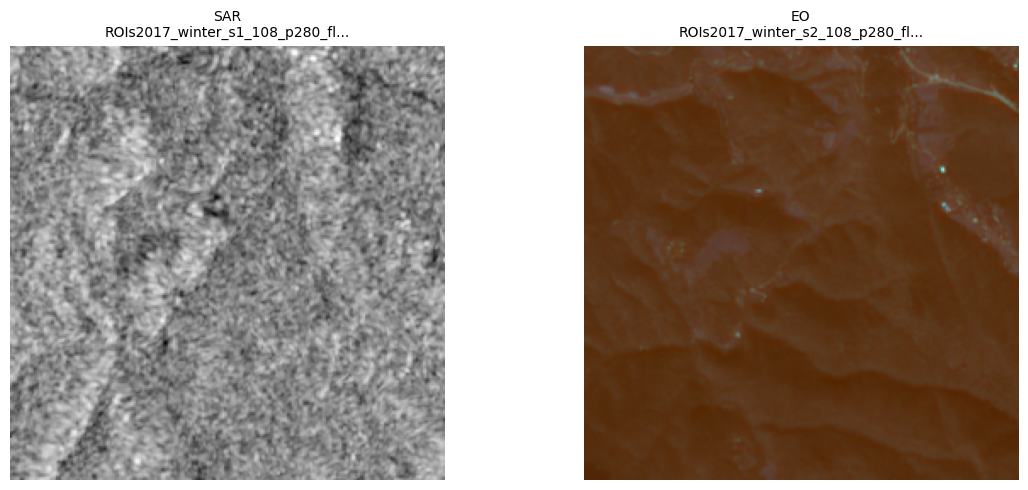

✅ Successfully validated pair
   SAR shape: (256, 256, 2), dtype: float32
   EO shape: (256, 256, 13), dtype: uint16
   SAR value range: [-26.105, 0.000]
   EO value range: [6.000, 3430.000]

--- Validating Pair 2 ---
SAR: ROIs2017_winter_s1_121_p455_original.tif
EO:  ROIs2017_winter_s2_121_p455_original.tif


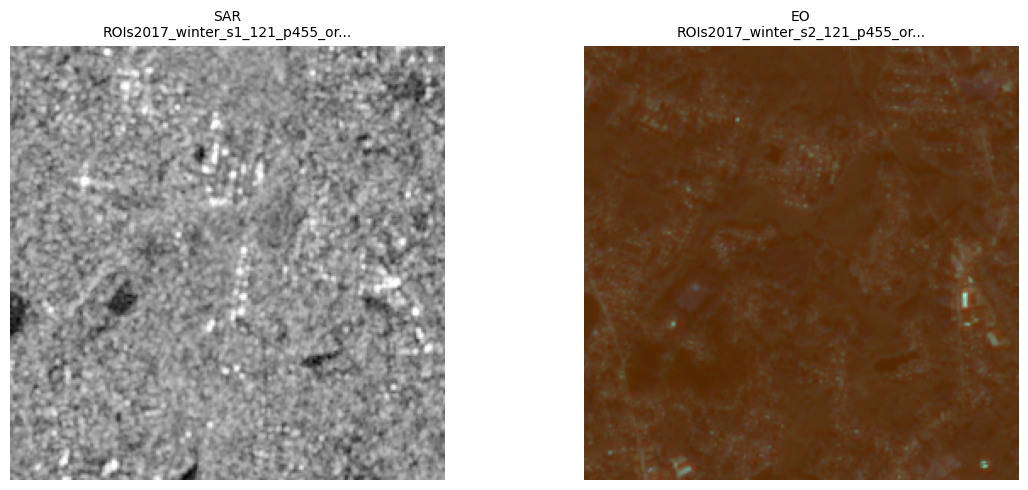

✅ Successfully validated pair
   SAR shape: (256, 256, 2), dtype: float32
   EO shape: (256, 256, 13), dtype: uint16
   SAR value range: [-30.012, 0.000]
   EO value range: [6.000, 5138.000]

--- Validating Pair 3 ---
SAR: ROIs2017_winter_s1_25_p253_flip_vertical_contrast.tif
EO:  ROIs2017_winter_s2_25_p253_flip_vertical_contrast.tif


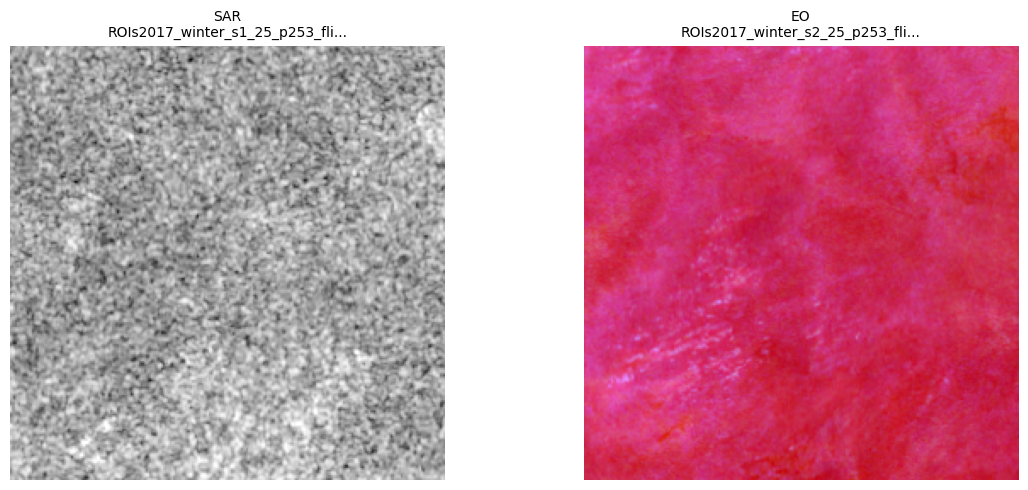

✅ Successfully validated pair
   SAR shape: (256, 256, 2), dtype: float32
   EO shape: (256, 256, 13), dtype: uint16
   SAR value range: [-30.062, -8.916]
   EO value range: [13.000, 3693.000]

--- Validating Pair 4 ---
SAR: ROIs2017_winter_s1_25_p564_affine.tif
EO:  ROIs2017_winter_s2_25_p564_affine.tif


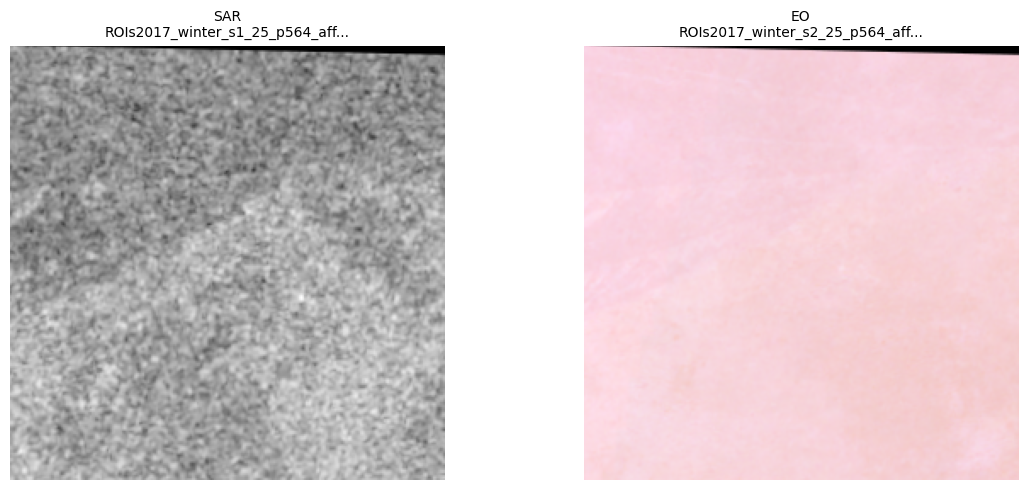

✅ Successfully validated pair
   SAR shape: (256, 256, 2), dtype: float32
   EO shape: (256, 256, 13), dtype: uint16
   SAR value range: [-30.062, -4.858]
   EO value range: [12.000, 3438.000]

--- Validating Pair 5 ---
SAR: ROIs2017_winter_s1_138_p57_flip_horizontal.tif
EO:  ROIs2017_winter_s2_138_p57_flip_horizontal.tif


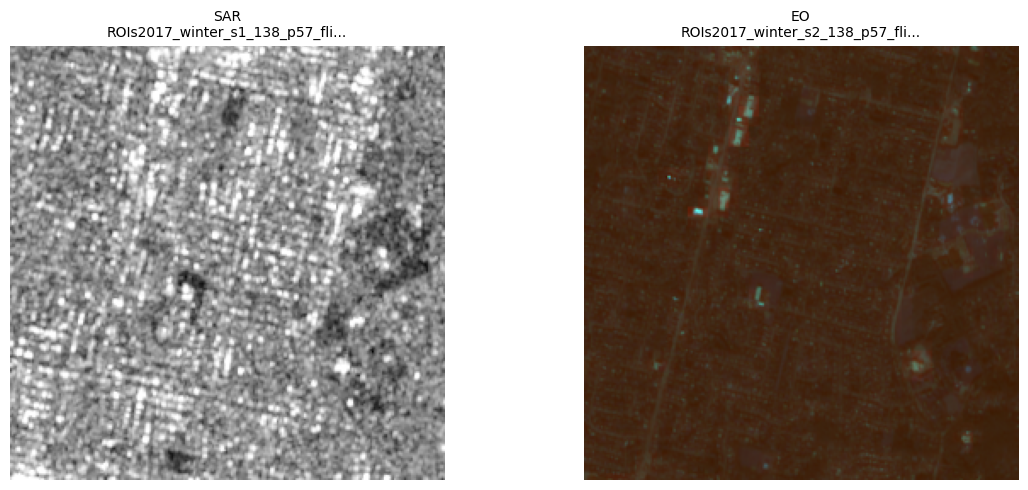

✅ Successfully validated pair
   SAR shape: (256, 256, 2), dtype: float32
   EO shape: (256, 256, 13), dtype: uint16
   SAR value range: [-30.121, 0.000]
   EO value range: [7.000, 7479.000]

VALIDATION SUMMARY
Total pairs checked: 5
Successfully validated: 5
Failed validations: 0
Missing EO files: 0
Success rate: 100.0%


In [10]:
import os
import numpy as np
import random
from pathlib import Path
import matplotlib.pyplot as plt
import rasterio

def validate_augmented_samples(output_sar_folder, output_eo_folder, num_samples=5):
    """
    Standalone function to validate augmented SAR-EO samples
    
    Args:
        output_sar_folder (str): Path to augmented SAR folder
        output_eo_folder (str): Path to augmented EO folder
        num_samples (int): Number of samples to validate
    """
    output_sar = Path(output_sar_folder)
    output_eo = Path(output_eo_folder)
    
    # Check if folders exist
    if not output_sar.exists():
        print(f"SAR folder not found: {output_sar}")
        return
    
    if not output_eo.exists():
        print(f"EO folder not found: {output_eo}")
        return
    
    # Get list of augmented SAR files
    augmented_sar_files = list(output_sar.glob("*.tif"))
    if not augmented_sar_files:
        print("No augmented SAR files found!")
        return
    
    print(f"Found {len(augmented_sar_files)} augmented SAR files")
    
    # Sample random files for validation
    sample_files = random.sample(augmented_sar_files, min(num_samples, len(augmented_sar_files)))
    
    validation_results = {
        'total_checked': 0,
        'successful': 0,
        'failed': 0,
        'missing_eo': 0
    }
    
    for sar_file in sample_files:
        sar_filename = sar_file.name
        validation_results['total_checked'] += 1
        
        # Convert SAR filename to corresponding EO filename
        # Replace 's1' with 's2' in the filename
        eo_filename = sar_filename.replace('_s1_', '_s2_')
        
        print(f"\n--- Validating Pair {validation_results['total_checked']} ---")
        print(f"SAR: {sar_filename}")
        print(f"EO:  {eo_filename}")
        
        # Check if corresponding EO file exists
        eo_file_path = output_eo / eo_filename
        if not eo_file_path.exists():
            print(f"❌ Warning: Corresponding EO file not found: {eo_filename}")
            validation_results['missing_eo'] += 1
            continue
        
        try:
            # Load SAR file
            with rasterio.open(output_sar / sar_filename) as src:
                sar_aug = src.read().transpose(1, 2, 0)
                if sar_aug.shape[2] == 1:
                    sar_aug = sar_aug.squeeze()
            
            # Load EO file
            with rasterio.open(output_eo / eo_filename) as src:
                eo_aug = src.read().transpose(1, 2, 0)
            
            # Display validation
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
            
            # Display SAR
            if len(sar_aug.shape) == 2:
                ax1.imshow(sar_aug, cmap='gray')
            else:
                ax1.imshow(sar_aug[:, :, 0], cmap='gray')
            ax1.set_title(f'SAR\n{sar_filename[:30]}...', fontsize=10)
            ax1.axis('off')
            
            # Display EO
            if eo_aug.shape[2] >= 3:
                # Normalize for display if needed
                eo_display = eo_aug[:, :, :3]
                if eo_display.max() > 1:
                    eo_display = (eo_display - eo_display.min()) / (eo_display.max() - eo_display.min())
                ax2.imshow(eo_display)
            else:
                ax2.imshow(eo_aug[:, :, 0], cmap='gray')
            ax2.set_title(f'EO\n{eo_filename[:30]}...', fontsize=10)
            ax2.axis('off')
            
            plt.tight_layout()
            plt.show()
            
            print(f"✅ Successfully validated pair")
            print(f"   SAR shape: {sar_aug.shape}, dtype: {sar_aug.dtype}")
            print(f"   EO shape: {eo_aug.shape}, dtype: {eo_aug.dtype}")
            print(f"   SAR value range: [{sar_aug.min():.3f}, {sar_aug.max():.3f}]")
            print(f"   EO value range: [{eo_aug.min():.3f}, {eo_aug.max():.3f}]")
            
            validation_results['successful'] += 1
            
        except Exception as e:
            print(f"❌ Error validating pair: {e}")
            validation_results['failed'] += 1
    
    # Print summary
    print(f"\n{'='*50}")
    print("VALIDATION SUMMARY")
    print(f"{'='*50}")
    print(f"Total pairs checked: {validation_results['total_checked']}")
    print(f"Successfully validated: {validation_results['successful']}")
    print(f"Failed validations: {validation_results['failed']}")
    print(f"Missing EO files: {validation_results['missing_eo']}")
    
    success_rate = (validation_results['successful'] / validation_results['total_checked']) * 100
    print(f"Success rate: {success_rate:.1f}%")
    
    return validation_results


def main():
    # Define paths to your augmented dataset
    output_sar_folder = r"C:\Users\adars\Downloads\SAR-to-EO\augmented_dataset\SAR"
    output_eo_folder = r"C:\Users\adars\Downloads\SAR-to-EO\augmented_dataset\EO"
    
    # Validate 5 random samples
    print("Starting validation of augmented SAR-EO dataset...")
    results = validate_augmented_samples(
        output_sar_folder=output_sar_folder,
        output_eo_folder=output_eo_folder,
        num_samples=5
    )
    
    return results


if __name__ == "__main__":
    validation_results = main()